# Imports

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time

# Load statics

In [2]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [3]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2]
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [4]:
for course_num in valid_courses:

    ### Initialize BeuatifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    ### Find <tr> that contains "Academic prerequisites"
    search_string = "Academic prerequisites"
    
    # Find respective label
    label = soup.find('label', string=re.compile(search_string))
    if label is None:
        continue
    
    # Get element that contains the label + prerequisites
    parent = label.find_parent().find_parent()
    
    # Get second <td>
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and breaks (\n and \r)
    prerequisite  = prerequisite.replace('\r', ' ')
    prerequisite  = prerequisite.replace('\n ', '')

    # Extract 5 digit numbers (any course number)
    prerequisites = re.findall(r'\d{5}', prerequisite)
    
    # if course exists in graph, add edge
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite == course_num: 
                # Handle self-loops
                pass
            else:
                G.add_edge(course_num, prerequisite)

## Add text attributes

In [20]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

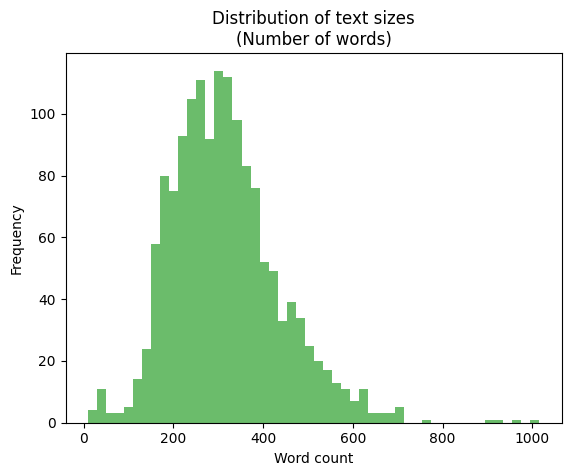

In [22]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7)
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [7]:
...

Ellipsis

# Degree distribution

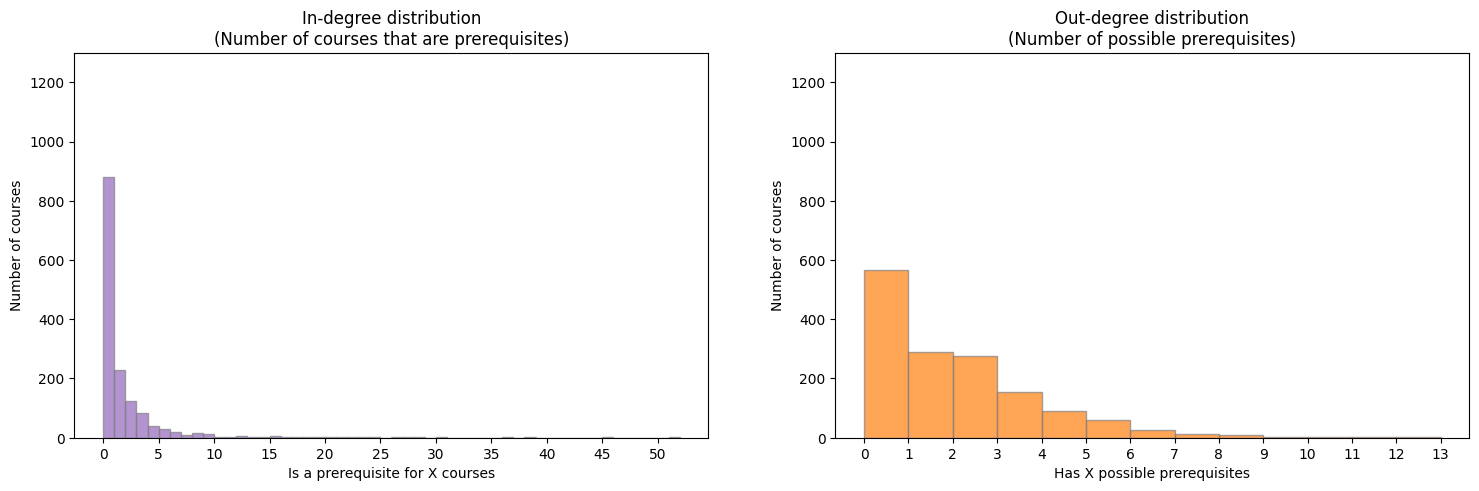

In [18]:
# Calculate in- and out-degrees. Show histogram
in_degrees = [G.in_degree(n) for n in G.nodes]
out_degrees = [G.out_degree(n) for n in G.nodes]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].set_ylim(0, 1300)
axs[0].hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2), color='C4', alpha=0.7, edgecolor='grey', label='In-degree (is a prerequisite)')
axs[0].set_xlabel('Is a prerequisite for X courses')
axs[0].set_ylabel('Number of courses')
axs[0].set_title('In-degree distribution\n(Number of courses that are prerequisites)')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(5))

axs[1].set_ylim(0, 1300)
axs[1].hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2), color='C1', alpha=0.7, edgecolor='grey', label='Out-degree (number of possible prerequisites)')
axs[1].set_xlabel('Has X possible prerequisites')
axs[1].set_ylabel('Number of courses')
axs[1].set_title('Out-degree distribution\n(Number of possible prerequisites)')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()

# Plotting

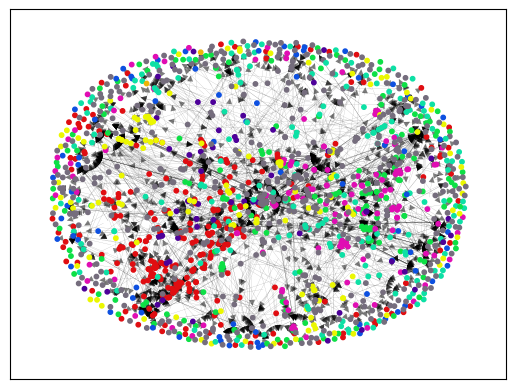

In [9]:
# Draw graph. Set color of nodes based on department
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrows=True, width=0.1, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=[G.nodes[n]['color'] for n in G.nodes])
plt.show()

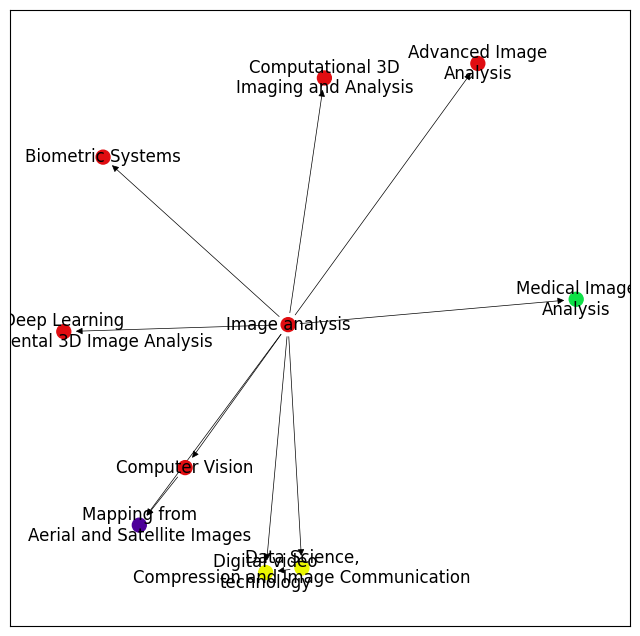

In [10]:
plt.figure(figsize=(8, 8))
H = G.reverse()
# H = G.to_undirected()
hub_egos = nx.ego_graph(H, '02502', radius=1)

# replace all long course titles with a \n version
for n in hub_egos.nodes:
    if len(hub_egos.nodes[n]['course_title']) > 20:
        hub_egos.nodes[n]['course_title'] = ' '.join(hub_egos.nodes[n]['course_title'].split(' ')[:2]) + '\n' + ' '.join(hub_egos.nodes[n]['course_title'].split(' ')[2:])

pos = nx.spring_layout(hub_egos)
nx.draw_networkx_edges(hub_egos, pos, edgelist=hub_egos.edges, arrows=True, width=0.5, alpha=1)
nx.draw_networkx_nodes(hub_egos, pos, node_size=100, node_color=[hub_egos.nodes[n]['color'] for n in hub_egos.nodes])
nx.draw_networkx_labels(hub_egos, pos, labels={n: hub_egos.nodes[n]['course_title'] for n in hub_egos.nodes}, font_size=12)

# larger figure

plt.show()